In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

In [2]:
data_path = 'OV.methylation__humanmethylation450__jhu_usc_edu__Level_3__within_bioassay_data_set_function__data.data.txt'
df = pd.read_csv(data_path, sep='\t')

/var/folders/_g/ncq8t9cn3y97t4_nz1ds47c40000gn/T/ipykernel_74882/2888831559.py:2: DtypeWarning: Columns (1,4,5,8,9,12,13,16,17,20,21,24,25,28,29,32,33,36,37,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')


In [3]:
sample = df.columns # keep sample names

# changing structure of data frame
df.columns = df.iloc[0]
df = df.drop(0)
df = df.set_index(df.columns[0])

df.head()

,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,...,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate
Composite Element REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.162232896986279,RBL2,16,53468112,0.191627667901702,RBL2,16,53468112,0.0712181967886229,RBL2,...,16,53468112,0.0681542463965581,RBL2,16,53468112,0.101053013486289,RBL2,16,53468112
cg00000108,NaN,C3orf35,3,37459206,NaN,C3orf35,3,37459206,NaN,C3orf35,...,3,37459206,NaN,C3orf35,3,37459206,NaN,C3orf35,3,37459206
cg00000109,NaN,FNDC3B,3,171916037,NaN,FNDC3B,3,171916037,NaN,FNDC3B,...,3,171916037,NaN,FNDC3B,3,171916037,NaN,FNDC3B,3,171916037
cg00000165,0.0774981107114241,NaN,1,91194674,0.539213127355674,NaN,1,91194674,0.0804679362519497,NaN,...,1,91194674,0.218775162768368,NaN,1,91194674,0.091250661927779,NaN,1,91194674
cg00000236,0.887426943347337,VDAC3,8,42263294,0.919352685107726,VDAC3,8,42263294,0.873067094340102,VDAC3,...,8,42263294,0.894063237620977,VDAC3,8,42263294,0.909250402621734,VDAC3,8,42263294


In [4]:
# check NaN value
df.isna().sum()

0
Beta_value             89725
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89725
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89709
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89747
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89723
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89772
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89710
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89761
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89715
Gene_Symbol           119717
Chromosome  

In [5]:
# Filtering genes with NaN values in Beta_value column
df = df.dropna(subset=['Beta_value'])
df.head()

,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,...,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate
Composite Element REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.162232896986279,RBL2,16,53468112,0.191627667901702,RBL2,16,53468112,0.0712181967886229,RBL2,...,16,53468112,0.0681542463965581,RBL2,16,53468112,0.101053013486289,RBL2,16,53468112
cg00000165,0.0774981107114241,NaN,1,91194674,0.539213127355674,NaN,1,91194674,0.0804679362519497,NaN,...,1,91194674,0.218775162768368,NaN,1,91194674,0.091250661927779,NaN,1,91194674
cg00000236,0.887426943347337,VDAC3,8,42263294,0.919352685107726,VDAC3,8,42263294,0.873067094340102,VDAC3,...,8,42263294,0.894063237620977,VDAC3,8,42263294,0.909250402621734,VDAC3,8,42263294
cg00000289,0.70623334856886,ACTN1,14,69341139,0.585941172707428,ACTN1,14,69341139,0.53560092563212,ACTN1,...,14,69341139,0.45159368326575,ACTN1,14,69341139,0.718101311137447,ACTN1,14,69341139
cg00000292,0.600543186657216,ATP2A1,16,28890100,0.81526047238347,ATP2A1,16,28890100,0.340245216172717,ATP2A1,...,16,28890100,0.929602191814778,ATP2A1,16,28890100,0.637718731276499,ATP2A1,16,28890100


In [6]:
# Drop redundant Gene_symbol, Chromosome and Genomic_Coordinate columns

# Keep only the first occurrence of specific columns
columns_to_deduplicate = ['Chromosome', 'Gene_Symbol', 'Genomic_Coordinate']
df = df.loc[:, ~df.columns.duplicated(keep='first') | ~df.columns.isin(columns_to_deduplicate)]

# Check the updated DataFrame
df.head()

,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value
Composite Element REF,,,,,,,,,,,,,
cg00000029,0.162232896986279,RBL2,16,53468112,0.191627667901702,0.0712181967886229,0.0797617926225958,0.134907151266991,0.0541415985613948,0.0898579298345672,0.037865566345129,0.0681542463965581,0.101053013486289
cg00000165,0.0774981107114241,NaN,1,91194674,0.539213127355674,0.0804679362519497,0.116847394499493,0.240761474867287,0.0731841811860166,0.117232830385723,0.44386976357312,0.218775162768368,0.091250661927779
cg00000236,0.887426943347337,VDAC3,8,42263294,0.919352685107726,0.873067094340102,0.916907354805292,0.899778425612948,0.886990509454191,0.902827859783123,0.914979623404746,0.894063237620977,0.909250402621734
cg00000289,0.70623334856886,ACTN1,14,69341139,0.585941172707428,0.53560092563212,0.671885140457963,0.529425616903779,0.638185069667011,0.470522232834328,0.68323363569591,0.45159368326575,0.718101311137447
cg00000292,0.600543186657216,ATP2A1,16,28890100,0.81526047238347,0.340245216172717,0.846848323745542,0.793461162099088,0.394033633901396,0.457197228355476,0.920116383428113,0.929602191814778,0.637718731276499


In [7]:
# Extract only Beta_value columns
beta_value_columns = [index for index, column in enumerate(df.columns) if 'Beta_value' in column]
beta_values = df.iloc[:, beta_value_columns]

In [8]:
# Convert these values from string to float, calculate standard deviation and place it in the separate column
beta_values = beta_values.apply(pd.to_numeric, errors='coerce')
std_dev = beta_values.std(axis=1)
df['std_dev'] = std_dev

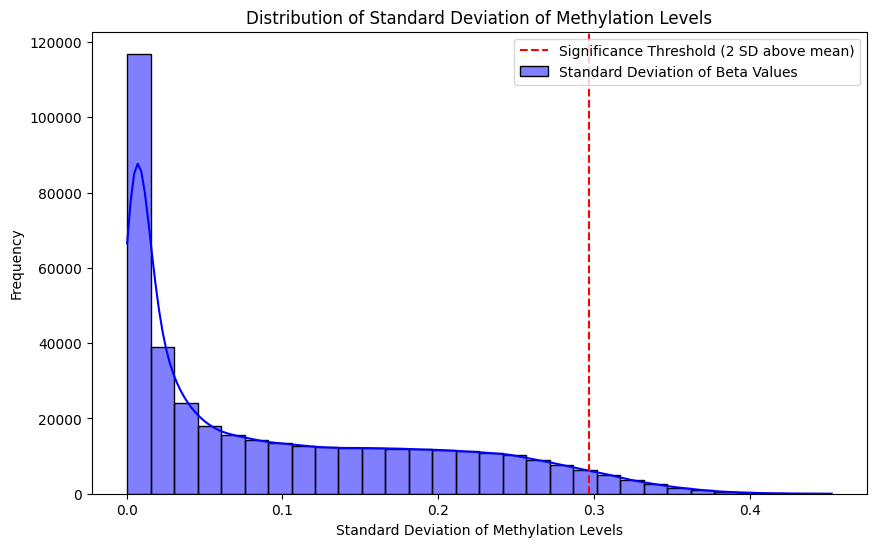

Threshold:  0.29687684557548
Number of significant methylation values: 16622


In [9]:
# Calculate the mean and standard deviation of the std_dev values
mean_std_dev = std_dev.mean()
std_dev_std_dev = std_dev.std()

# Set the threshold for significant methylation change (e.g., 2 standard deviations above the mean)
threshold = mean_std_dev + 2 * std_dev_std_dev

# Plot the histogram of standard deviations
plt.figure(figsize=(10, 6))
sns.histplot(std_dev, kde=True, color='blue', bins=30, label='Standard Deviation of Beta Values')

# Add a vertical line for the threshold
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Significance Threshold (2 SD above mean)')

# Add labels and title
plt.xlabel('Standard Deviation of Methylation Levels')
plt.ylabel('Frequency')
plt.title('Distribution of Standard Deviation of Methylation Levels')
plt.legend()

# Show the plot
plt.show()

significant = df[df['std_dev'] >= threshold]
print("Threshold: ", threshold)
print(f"Number of significant methylation values: {len(significant)}")

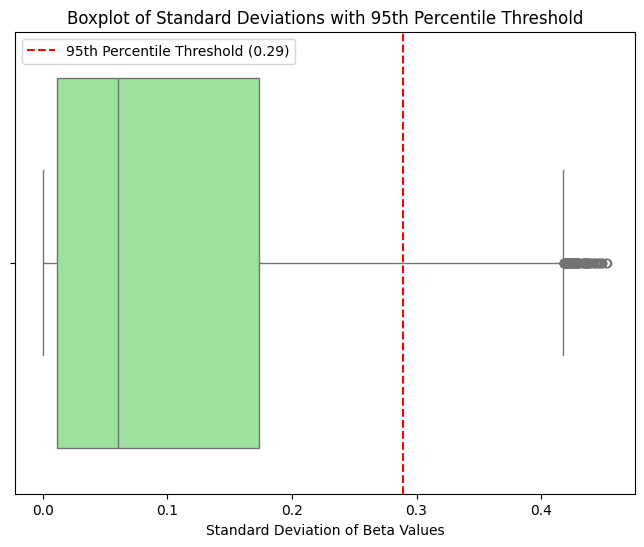

Percentile threshold:  0.2892595983816986
Number of significant methylation values: 19779


In [10]:
# Create a boxplot to visualize the distribution of the standard deviations of beta values
plt.figure(figsize=(8, 6))
sns.boxplot(data=std_dev, orient='h', color = 'lightgreen')

# Calculate the 95th percentile threshold
percentile_threshold = np.percentile(std_dev, 95)

# Overlay the threshold line
plt.axvline(x=percentile_threshold, color='red', linestyle='--', label=f'95th Percentile Threshold ({percentile_threshold:.2f})')

# Labels and title
plt.xlabel('Standard Deviation of Beta Values')
plt.title('Boxplot of Standard Deviations with 95th Percentile Threshold')
plt.legend()

# Show the plot
plt.show()

significant = df[df['std_dev'] >= percentile_threshold]
print("Percentile threshold: ", percentile_threshold)
print(f"Number of significant methylation values: {len(significant)}")

In [11]:
# Use mean value of obtained thresholds
threshold = (threshold + percentile_threshold) / 2

# Filter genes with significant variation in levels of methylation
df = df[df['std_dev'] >= threshold]
df = df.drop('std_dev', axis = 1)

print("Threshold: ", threshold)
print(f"Number of significant methylation values: {len(df)}")

Threshold:  0.2930682219785893
Number of significant methylation values: 18120


In [12]:
# Extract only Beta_value columns for filtered genes
beta_value_columns = [index for index, column in enumerate(df.columns) if 'Beta_value' in column]
beta_values = df.iloc[:, beta_value_columns]
beta_values = beta_values.apply(pd.to_numeric, errors='coerce')

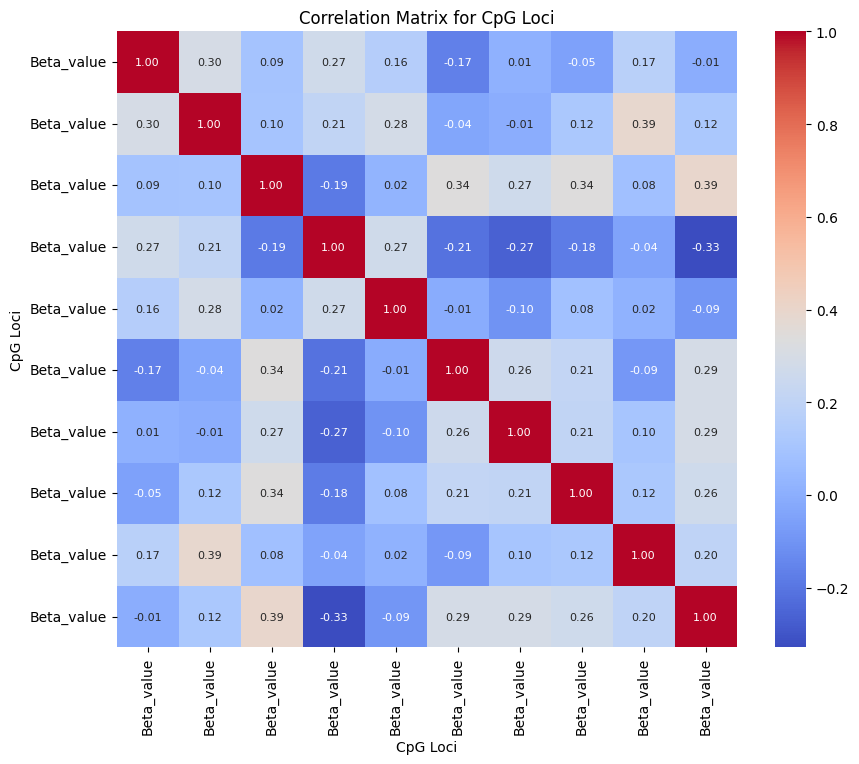

In [13]:
# Compute correlation matrix for CpG loci
correlation_matrix = beta_values.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Matrix for CpG Loci')
plt.xlabel('CpG Loci')
plt.ylabel('CpG Loci')
plt.show()

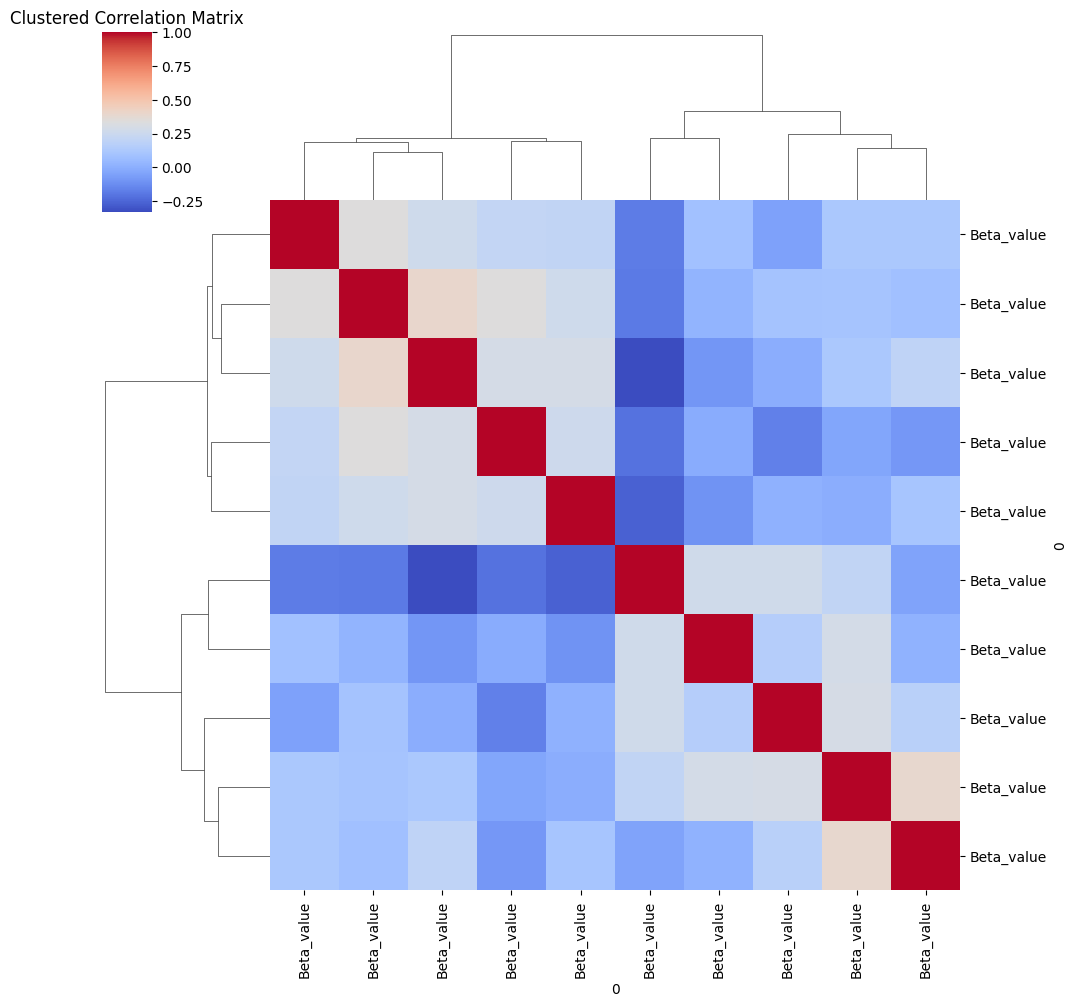

In [14]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering for better visualisation of correlations
linkage_matrix = linkage(correlation_matrix, method='ward')

# Plot a clustered heatmap
sns.clustermap(correlation_matrix, cmap='coolwarm', figsize=(10, 10), row_linkage=linkage_matrix, col_linkage=linkage_matrix)
plt.title('Clustered Correlation Matrix')
plt.show()

## Clustering by CpG loci

### KMeans

n_clusters: 2, Silhouette Score: 0.1888, Calinski Harabasz: 4175.5390, Davies-Bouldin: 2.0398
n_clusters: 3, Silhouette Score: 0.1724, Calinski Harabasz: 3538.9779, Davies-Bouldin: 1.9800
n_clusters: 4, Silhouette Score: 0.1478, Calinski Harabasz: 3090.4343, Davies-Bouldin: 1.8727
n_clusters: 5, Silhouette Score: 0.1357, Calinski Harabasz: 2638.9922, Davies-Bouldin: 1.9524
n_clusters: 6, Silhouette Score: 0.1357, Calinski Harabasz: 2457.9960, Davies-Bouldin: 1.8783
n_clusters: 7, Silhouette Score: 0.1388, Calinski Harabasz: 2299.5870, Davies-Bouldin: 1.9231
n_clusters: 8, Silhouette Score: 0.1315, Calinski Harabasz: 2116.3896, Davies-Bouldin: 1.9750
n_clusters: 9, Silhouette Score: 0.1364, Calinski Harabasz: 2030.0288, Davies-Bouldin: 1.9322
n_clusters: 10, Silhouette Score: 0.1173, Calinski Harabasz: 1895.7746, Davies-Bouldin: 1.9372
n_clusters: 11, Silhouette Score: 0.1440, Calinski Harabasz: 1862.5831, Davies-Bouldin: 1.8400
n_clusters: 12, Silhouette Score: 0.1331, Calinski Harabas

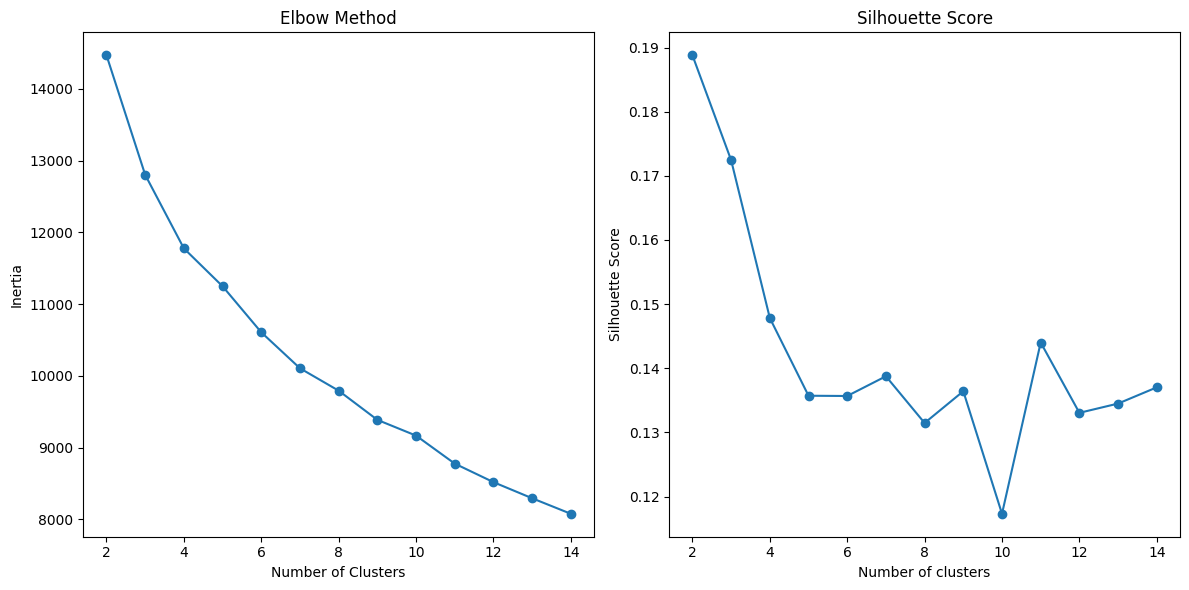


Best Results:
Best Silhouette Score: 0.1888 with parameters {'n_clusters': 2}
Best Calinski-Harabasz Score: 4175.5390 with parameters {'n_clusters': 2}
Best Davies-Bouldin Score: 1.7309 with parameters {'n_clusters': 14}


In [15]:
param_grid = {'n_clusters': range(2, 15)}

grid_search = ParameterGrid(param_grid)

# Initialize variables to store the best scores
best_silhouette_score = -1
best_calinski_harabasz_score = -1
best_davies_bouldin_score = float('inf')  # Lower is better
best_params_silhouette = None
best_params_calinski = None
best_params_davies = None

# Store results for the Elbow Method and Silhouette scores
inertia = []
silhouette_scores = []

for params in grid_search:
    kmeans = KMeans(n_clusters=params['n_clusters'], random_state=42)
    clusters = kmeans.fit_predict(beta_values)

    # Calculate metrics
    score_silhouette = silhouette_score(beta_values, clusters)
    score_calinski_harabasz = calinski_harabasz_score(beta_values, clusters)
    score_davies_bouldin = davies_bouldin_score(beta_values, clusters)
    inertia.append(kmeans.inertia_)  # Elbow Method
    silhouette_scores.append(score_silhouette) 
    
    print(f"n_clusters: {params['n_clusters']}, "
          f"Silhouette Score: {score_silhouette:.4f}, "
          f"Calinski Harabasz: {score_calinski_harabasz:.4f}, "
          f"Davies-Bouldin: {score_davies_bouldin:.4f}"
)

    # Update the best scores and parameters
    if score_silhouette > best_silhouette_score:
        best_silhouette_score = score_silhouette
        best_params_silhouette = params

    if score_calinski_harabasz > best_calinski_harabasz_score:
        best_calinski_harabasz_score = score_calinski_harabasz
        best_params_calinski = params

    if score_davies_bouldin < best_davies_bouldin_score:
        best_davies_bouldin_score = score_davies_bouldin
        best_params_davies = params


# Plot Elbow Method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')


# Silhouette score visualization
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Print the best results
print("\nBest Results:")
print(f"Best Silhouette Score: {best_silhouette_score:.4f} with parameters {best_params_silhouette}")
print(f"Best Calinski-Harabasz Score: {best_calinski_harabasz_score:.4f} with parameters {best_params_calinski}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin_score:.4f} with parameters {best_params_davies}")

In [20]:
k_values = range(1, len(inertia) + 1)
knee_locator = KneeLocator(k_values, inertia, curve = "convex", direction="decreasing")
elbow_point = knee_locator.knee
print(f"The optimal number of clusters (elbow point) is: {elbow_point}")

The optimal number of clusters (elbow point) is: 5


- Silhouette and Calinski-Harabasz suggest n_clusters=2 as the optimal value.
- Davies-Bouldin and the Elbow Method suggest n_clusters=4–5 or possibly more.
- A low Silhouette Score and a gradually decreasing inertia suggest that the dataset may lack distinct clusters.
- The low scores across all metrics imply that the data may have overlapping clusters or no inherent cluster structure.
- Based on all this, we can conclude that KMeans is not appropriate algorithm for this clustering task.

### DBSCAN

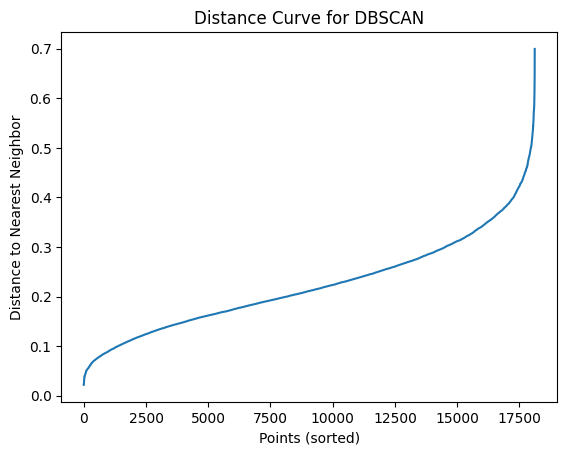

In [57]:
# Searching for optimal eps value based on distance curve
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(beta_values)
distances, _ = neigh.kneighbors(beta_values)
distances = np.sort(distances, axis=0)[:, 1]

# Distance curve visualization
plt.plot(distances)
plt.title('Distance Curve for DBSCAN')
plt.xlabel('Points (sorted)')
plt.ylabel('Distance to Nearest Neighbor')
plt.show()


Based on the displayed curve, we can observe that a sudden increase occurs at the value eps = 0.4. Therefore, we will use this value to form the DBSCAN model. For the parameter min_samples, we will take, for example, the number 25, since we have a large number of points in the dataset.

In [58]:
dbscan = DBSCAN(eps=0.4, min_samples=25)
region_clusters = dbscan.fit_predict(beta_values)

# We can enumerate clusters and how many elements there are in each of them. Since data is 10-dimensional, its visualization is difficult
# to achieve, hence we will only enumerate clusters

counter = Counter(region_clusters)
sorted_clusters = {k : counter[k] for k in sorted(counter)}
print(sorted_clusters)

{-1: 5701, 0: 12272, 1: 101, 2: 46}


In [59]:
silhouette = silhouette_score(beta_values, region_clusters)
calinski = calinski_harabasz_score(beta_values, region_clusters)
davies = davies_bouldin_score(beta_values, region_clusters)
print(f"Silhouette Score: {silhouette:.4f}, "
  f"Calinski Harabasz: {calinski:.4f}, "
  f"Davies-Bouldin: {davies:.4f}")

Silhouette Score: 0.0332, Calinski Harabasz: 588.3179, Davies-Bouldin: 2.2992


- The results indicate that the clustering performance of DBSCAN with the current parameters is weak.
- The low Silhouette Score and high Davies-Bouldin Index highlight that the clusters are not distinct or meaningful.
- Based on all this, we can conclude that DBSCAN is not appropriate algorithm for this clustering task.

### Hierarchical clustering 

n_clusters: 2, Silhouette Score: 0.1215, Calinski Harabasz: 2754.2241, Davies-Bouldin: 2.3817
n_clusters: 3, Silhouette Score: 0.1357, Calinski Harabasz: 2655.8064, Davies-Bouldin: 2.2801
n_clusters: 4, Silhouette Score: 0.0938, Calinski Harabasz: 2328.9707, Davies-Bouldin: 2.1463
n_clusters: 5, Silhouette Score: 0.0960, Calinski Harabasz: 2039.6526, Davies-Bouldin: 2.3168
n_clusters: 6, Silhouette Score: 0.1003, Calinski Harabasz: 1856.0994, Davies-Bouldin: 2.1328
n_clusters: 7, Silhouette Score: 0.1072, Calinski Harabasz: 1734.3804, Davies-Bouldin: 2.3455
n_clusters: 8, Silhouette Score: 0.1127, Calinski Harabasz: 1649.5181, Davies-Bouldin: 2.1892
n_clusters: 9, Silhouette Score: 0.0891, Calinski Harabasz: 1557.7829, Davies-Bouldin: 2.1681
n_clusters: 10, Silhouette Score: 0.0933, Calinski Harabasz: 1490.4543, Davies-Bouldin: 2.0960
n_clusters: 11, Silhouette Score: 0.0857, Calinski Harabasz: 1430.1590, Davies-Bouldin: 2.0709
n_clusters: 12, Silhouette Score: 0.0899, Calinski Harabas

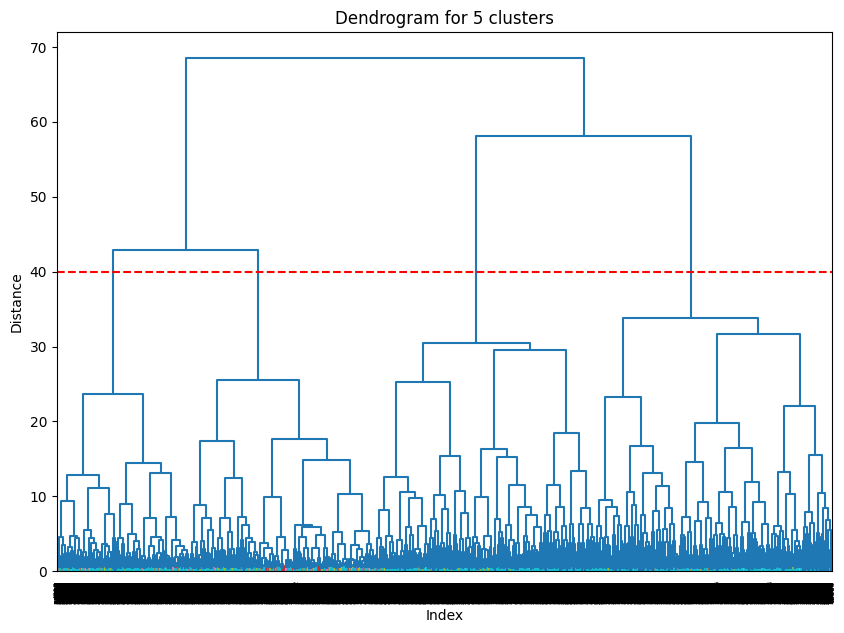

In [65]:
param_grid = {'n_clusters': range(2, 15)}

grid_search = ParameterGrid(param_grid)

# Initialize variables to store the best scores
best_silhouette_score = -1
best_calinski_harabasz_score = -1
best_davies_bouldin_score = float('inf')  # Lower is better
best_params_silhouette = None
best_params_calinski = None
best_params_davies = None

silhouette_scores = []

linked = linkage(beta_values, method='ward')

for params in grid_search:
    clusters = fcluster(linked, t=params['n_clusters'], criterion='maxclust')
    score_silhouette = silhouette_score(beta_values, clusters)
    score_calinski_harabasz = calinski_harabasz_score(beta_values, clusters)
    score_davies_bouldin = davies_bouldin_score(beta_values, clusters)
    
    silhouette_scores.append((params['n_clusters'], score_silhouette))

    print(f"n_clusters: {params['n_clusters']}, "
          f"Silhouette Score: {score_silhouette:.4f}, "
          f"Calinski Harabasz: {score_calinski_harabasz:.4f}, "
          f"Davies-Bouldin: {score_davies_bouldin:.4f}"
)

    # Update the best scores and parameters
    if score_silhouette > best_silhouette_score:
        best_silhouette_score = score_silhouette
        best_params_silhouette = params

    if score_calinski_harabasz > best_calinski_harabasz_score:
        best_calinski_harabasz_score = score_calinski_harabasz
        best_params_calinski = params

    if score_davies_bouldin < best_davies_bouldin_score:
        best_davies_bouldin_score = score_davies_bouldin
        best_params_davies = params


# Print the best results
print("\nBest Results:")
print(f"Best Silhouette Score: {best_silhouette_score:.4f} with parameters {best_params_silhouette}")
print(f"Best Calinski-Harabasz Score: {best_calinski_harabasz_score:.4f} with parameters {best_params_calinski}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin_score:.4f} with parameters {best_params_davies}")

# Dendrogram for best number of clusters - regarding silhouette
best_clusters = fcluster(linked, t=best_n_clusters_sil, criterion='maxclust')
plt.figure(figsize=(10, 7))
dendrogram(linked, color_threshold=0.7)
plt.axhline(y=40, color='r', linestyle='--')
plt.title(f'Dendrogram for {best_n_clusters_sil} clusters')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

- The low Silhouette and high Davies-Bouldin Scores suggest that this dataset does not have a strong inherent cluster structure or that the chosen distance metric/linkage method might not be capturing the data's true relationships.
- While the metrics highlight different optimal cluster counts (n_clusters=3 for Silhouette, n_clusters=2 for Calinski-Harabasz, and n_clusters=13 for Davies-Bouldin), none indicate a strong, meaningful clustering structure.
- Based on all this, we can conclude that Hierarchical clustering is not appropriate algorithm for this clustering task.

### GMM

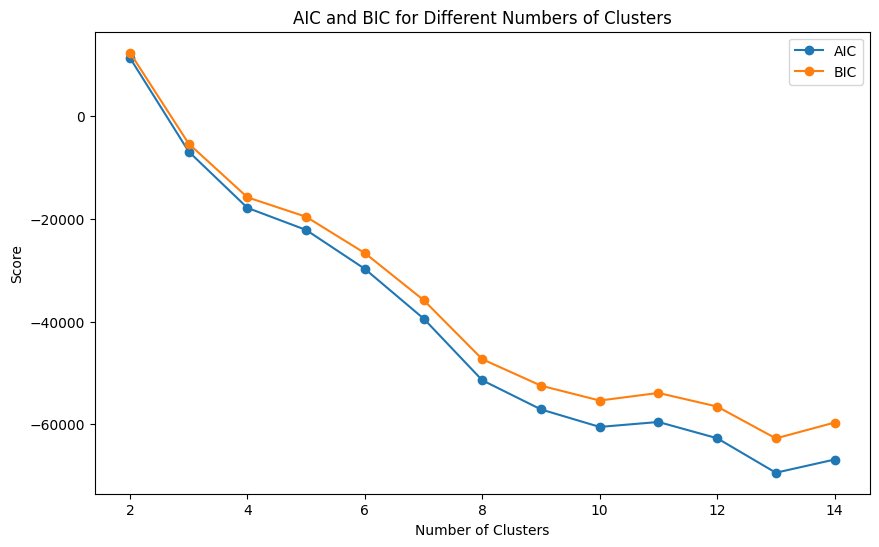

Best Scores and Parameters:
Best Silhouette Score: 0.1238 at {'n_clusters': 2}
Best Calinski-Harabasz Score: 2913.4824 with parameters {'n_clusters': 2}
Best Davies-Bouldin Score: 2.3187 with parameters {'n_clusters': 2}
Best AIC: -69459.1287 at {'n_clusters': 13}
Best BIC: -62770.4394 at {'n_clusters': 13}
Best Log-Likelihood: 35586.5643 at {'n_clusters': 13}


In [74]:
param_grid = {'n_clusters': range(2, 15)}

grid_search = ParameterGrid(param_grid)

# Initialize best score variables
best_silhouette_score = -1
best_aic = float('inf')  # Lower is better
best_bic = float('inf')  # Lower is better
best_log_likelihood = -float('inf')  # Higher is better
best_calinski_harabasz_score = -1
best_davies_bouldin_score = float('inf')  # Lower is better


# Initialize best parameter trackers
best_params_silhouette = None
best_params_aic = None
best_params_bic = None
best_params_log_likelihood = None
best_params_calinski = None
best_params_davies = None

results = []
aic_scores = []
bic_scores = []

for params in grid_search:
    gmm = GaussianMixture(n_components=params['n_clusters'], random_state=42)
    clusters = gmm.fit_predict(beta_values)

    silhouette = silhouette_score(beta_values, clusters) if n_clusters > 1 else None  # Silhouette requires at least 2 clusters
    score_calinski_harabasz = calinski_harabasz_score(beta_values, clusters)
    score_davies_bouldin = davies_bouldin_score(beta_values, clusters)
    aic = gmm.aic(beta_values)
    bic = gmm.bic(beta_values)
    log_likelihood = gmm.score(beta_values) * len(beta_values)  # Total log-likelihood

    aic_scores.append(aic)
    bic_scores.append(bic)
    
    if silhouette is not None and silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        best_params_silhouette = params
    
    if aic < best_aic:
        best_aic = aic
        best_params_aic = params
    
    if bic < best_bic:
        best_bic = bic
        best_params_bic = params
  
    if log_likelihood > best_log_likelihood:
        best_log_likelihood = log_likelihood
        best_params_log_likelihood = params

    if score_calinski_harabasz > best_calinski_harabasz_score:
        best_calinski_harabasz_score = score_calinski_harabasz
        best_params_calinski = params

    if score_davies_bouldin < best_davies_bouldin_score:
        best_davies_bouldin_score = score_davies_bouldin
        best_params_davies = params
    

# Visualization of AIC and BIC results
plt.figure(figsize=(10, 6))
plt.plot(range(2,15), aic_scores, label='AIC', marker='o')
plt.plot(range(2,15), bic_scores, label='BIC', marker='o')
plt.title('AIC and BIC for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

# Print best scores and parameters
print("Best Scores and Parameters:")
print(f"Best Silhouette Score: {best_silhouette_score:.4f} at {best_params_silhouette}")
print(f"Best Calinski-Harabasz Score: {best_calinski_harabasz_score:.4f} with parameters {best_params_calinski}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin_score:.4f} with parameters {best_params_davies}")
print(f"Best AIC: {best_aic:.4f} at {best_params_aic}")
print(f"Best BIC: {best_bic:.4f} at {best_params_bic}")
print(f"Best Log-Likelihood: {best_log_likelihood:.4f} at {best_params_log_likelihood}")

- 2 Clusters: Metrics like Silhouette Score, Calinski-Harabasz, and Davies-Bouldin suggest that the data can be divided into 2 broad groups, but the clusters are not particularly distinct.
- 13 Clusters: AIC, BIC, and Log-Likelihood indicate that the data may support a more granular division with 13 clusters, though this could result in overfitting or noise-driven clustering.
- None of the metrics indicate exceptionally strong clustering performance

### Spectral Clustering

In [83]:
# Apply Spectral Clustering for different number of clusters, searching for the most optimal one
best_silhouette = -1
optimal_silhouette = None # optimal number of clusters
best_calinski_harabasz = -1
optimal_calinski = None
best_davies_bouldin = float('inf')  # Lower is better
optimal_davies = None

for n_cluster in range(2, 10):
    spectral = SpectralClustering(n_clusters=n_cluster, affinity='nearest_neighbors', random_state=42)
    clusters = spectral.fit_predict(beta_values.T)
    sil = silhouette_score(beta_values.T, clusters)
    cal = calinski_harabasz_score(beta_values.T, clusters)
    dav = davies_bouldin_score(beta_values.T, clusters)
    if sil > best_silhouette:
        best_silhouette = sil
        optimal_silhouette = n_cluster
    if cal > best_calinski_harabasz:
        best_calinski_harabasz = cal
        optimal_calinski = n_cluster
    if dav < best_davies_bouldin:
        best_davies_bouldin = dav
        optimal_davies = n_cluster
    
# Print the best results for each metric
print()
print(f"Best Silhouette Score: {best_silhouette:.4f} Number of clusters: {optimal_silhouette}")
print(f"Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f} Number of clusters: {optimal_calinski}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin:.4f} Number of clusters: {optimal_davies}")


Best Silhouette Score: -0.0161 Number of clusters: 2
Best Calinski-Harabasz Index: 1.3719 Number of clusters: 7
Best Davies-Bouldin Score: 0.6350 Number of clusters: 9


- The metrics suggest that Spectral Clustering struggles to find clear, well-separated clusters in data.
- While the Davies-Bouldin Score for 9 clusters is relatively good, the poor Silhouette Score and low Calinski-Harabasz Index indicate that the clustering structure is weak overall.

In [28]:
# Set the window size (16,330 base pairs)
window_size = 16330

# Ensure Genomic_Coordinate is numeric and sort data by chromosome and coordinate
df['Genomic_Coordinate'] = df['Genomic_Coordinate'].astype(int)
df_sorted = df.sort_values(by=['Chromosome', 'Genomic_Coordinate'])

# Assign each CpG locus to a window
df_sorted['Window'] = df_sorted['Genomic_Coordinate'] // window_size

# Group loci by window
grouped_windows = df_sorted.groupby(['Chromosome', 'Window'])

# Compute correlations and identify boundaries
window_mean_correlations = []

for (chromosome, window), group in grouped_windows:
    # Extract beta values for loci in this window
    beta_values_window = group.filter(like='Beta_value', axis=1)

    # Detect and exclude constant columns
    constant_columns = (beta_values_window.nunique() <= 1)
    if constant_columns.any():
        beta_values_window = beta_values_window.loc[:, ~constant_columns]
    
    # Compute mean correlation within the window
    if beta_values_window.shape[1] > 1:
        correlation_matrix = beta_values_window.corr()
        mean_correlation = correlation_matrix.stack().mean()
    else:
        mean_correlation = 0  # Single CpG in the window
    
    window_mean_correlations.append(mean_correlation)

# Detecting boundaries of region with sharp changes in methylation levels
threshold = np.percentile(window_mean_correlations, 95)
boundaries = [i for i, corr in enumerate(window_mean_correlations) if corr > threshold]

In [29]:
len(boundaries)

507

In [30]:
region_ranges = []

# Convert boundaries into region ranges
start = 0
for boundary in boundaries:
    region_ranges.append((start, boundary))
    start = boundary + 1
    
regions = []
for region in region_ranges:
    start, end = region
    region_data = df_sorted[(df_sorted['Window'] >= start) & (df_sorted['Window'] <= end)]
    mean_correlation = np.mean(window_mean_correlations[start:end + 1])
    
    # Append features for the region
    regions.append({
        'Mean_Correlation': mean_correlation
    })

# Create a DataFrame for clustering
regions_df = pd.DataFrame(regions)

In [31]:
regions_df.shape

(507, 1)

In [32]:
regions_df.head()

,Mean_Correlation
0,0.500000
1,0.221756
2,0.139747
3,0.778598
4,0.852149


## Region clustering

### KMeans

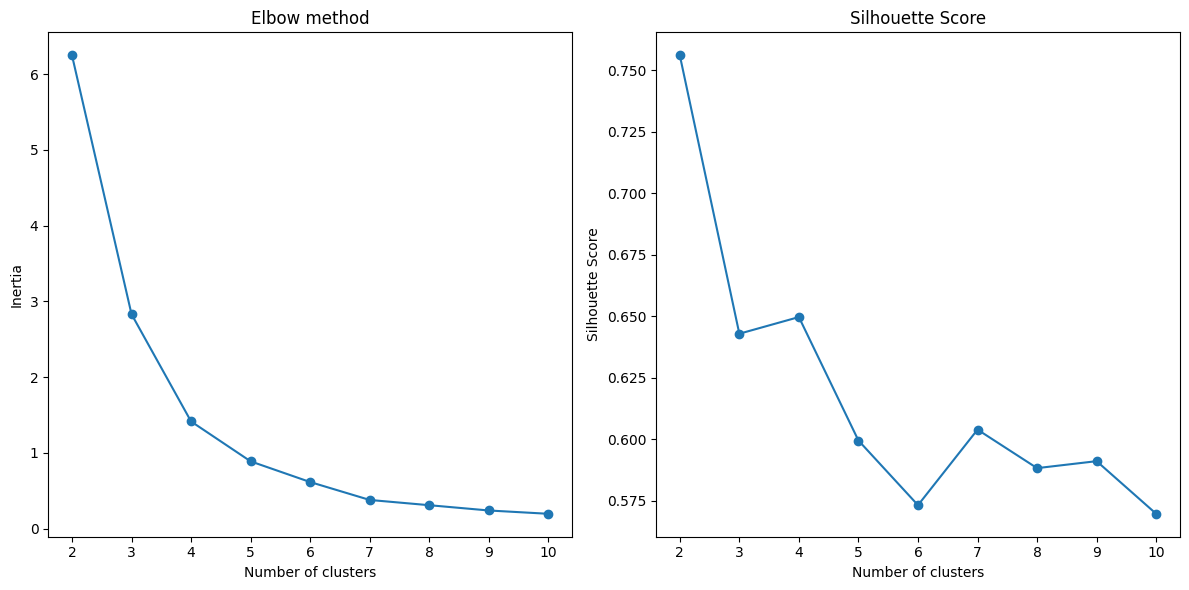

Silhouette Score suggests 2 clusters.


In [62]:
max_clusters = 10
inertias = []
silhouette_scores = []
for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(regions_df[['Mean_Correlation']])
    inertias.append(kmeans.inertia_)

    silhouette = silhouette_score(regions_df[['Mean_Correlation']], kmeans.labels_)
    silhouette_scores.append(silhouette)


# Elbow method visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Silhouette score visualization
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

optimal_k_silhouette = silhouette_scores.index(max(silhouette_scores)) + 2  # e.g. 5th element is the maximum -> 5 + 2 = 7 clusters
print(f"Silhouette Score suggests {optimal_k_silhouette} clusters.")

Considering the above elbow graph, we can say that optimal number of clusters (where the decrease rate doesn't further significantly drop) is around 7, hence the optimal number of clusters would be 7.

### DBSCAN

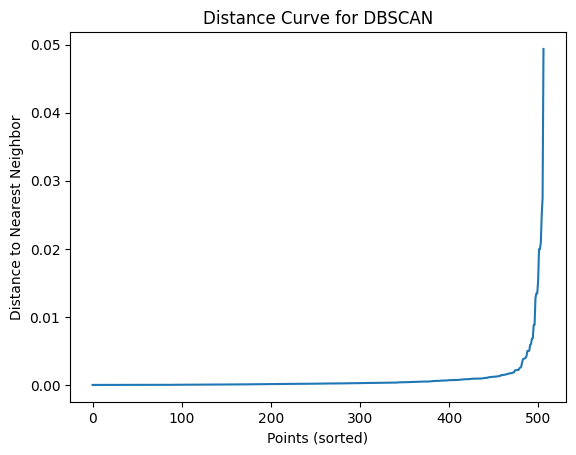

In [34]:
# Finding optimal eps using Distance Curve 
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(regions_df)
distances, _ = neigh.kneighbors(regions_df)
sorted_distances = np.sort(distances[:, 1]) 

# Visualising distance curve
import matplotlib.pyplot as plt
plt.plot(sorted_distances)
plt.title('Distance Curve for DBSCAN')
plt.xlabel('Points (sorted)')
plt.ylabel('Distance to Nearest Neighbor')
plt.show()

In [35]:
# Detect the elbow point
knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
optimal_eps = sorted_distances[knee_locator.knee]

print(f"Optimal eps value: {optimal_eps:.4f}")

Optimal eps value: 0.0199


In [68]:
# Define a range of min_samples values to test
min_samples_range = range(3, 15)

# Track the best results for each metric
best_silhouette_score = -1
best_calinski_score = -1
best_davies_score = float('inf')  # Lower is better
best_params_silhouette = None
best_params_calinski = None
best_params_davies = None

for min_samples in min_samples_range:
    # Apply DBSCAN with fixed eps and varying min_samples
    dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
    labels = dbscan.fit_predict(regions_df)
    
    # Check if there are at least 2 clusters (otherwise metrics are invalid)
    if len(set(labels)) > 1:
        # Compute clustering metrics
        silhouette = silhouette_score(regions_df, labels)
        calinski = calinski_harabasz_score(regions_df, labels)
        davies = davies_bouldin_score(regions_df, labels)
        
        n_clusters = len(np.unique(labels))
        
        print(f"min_samples: {min_samples}, "
          f"Silhouette Score: {silhouette:.4f}, "
          f"Calinski Harabasz: {calinski:.4f}, "
          f"Davies-Bouldin: {davies:.4f}, "
          f"Number of Clusters: {n_clusters}"
)
        
        # Update best Silhouette Score
        if silhouette > best_silhouette_score:
            best_silhouette_score = silhouette
            best_params_silhouette = (min_samples, n_clusters)
        
        # Update best Calinski-Harabasz Index
        if calinski > best_calinski_score:
            best_calinski_score = calinski
            best_params_calinski = (min_samples, n_clusters)
        
        # Update best Davies-Bouldin Score
        if davies < best_davies_score:
            best_davies_score = davies
            best_params_davies = (min_samples, n_clusters)

# Print the best results for each metric
print()
print(f"Best Silhouette Score: {best_silhouette_score:.4f} at min_samples={best_params_silhouette[0]}. Number of clusters: {best_params_silhouette[1]}")
print(f"Best Calinski-Harabasz Index: {best_calinski_score:.4f} at min_samples={best_params_calinski[0]}. Number of clusters: {best_params_calinski[1]}")
print(f"Best Davies-Bouldin Score: {best_davies_score:.4f} at min_samples={best_params_davies[0]}. Number of clusters: {best_params_davies[1]}")


min_samples: 3, Silhouette Score: 0.9256, Calinski Harabasz: 53282.5295, Davies-Bouldin: 0.5637, Number of Clusters: 10
min_samples: 4, Silhouette Score: 0.9256, Calinski Harabasz: 53282.5295, Davies-Bouldin: 0.5637, Number of Clusters: 10
min_samples: 5, Silhouette Score: 0.9245, Calinski Harabasz: 56946.6392, Davies-Bouldin: 0.3882, Number of Clusters: 9
min_samples: 6, Silhouette Score: 0.9245, Calinski Harabasz: 56946.6392, Davies-Bouldin: 0.3882, Number of Clusters: 9
min_samples: 7, Silhouette Score: 0.8774, Calinski Harabasz: 12972.5186, Davies-Bouldin: 1.0272, Number of Clusters: 7
min_samples: 8, Silhouette Score: 0.8575, Calinski Harabasz: 14676.8551, Davies-Bouldin: 1.0063, Number of Clusters: 6
min_samples: 9, Silhouette Score: 0.8492, Calinski Harabasz: 17751.5561, Davies-Bouldin: 0.8426, Number of Clusters: 5
min_samples: 10, Silhouette Score: 0.8492, Calinski Harabasz: 17751.5561, Davies-Bouldin: 0.8426, Number of Clusters: 5
min_samples: 11, Silhouette Score: 0.9281, Ca

- Across all three metrics, the optimal number of clusters is consistently 3, which strongly suggests that your data naturally forms three distinct groups.
- The results highlight the importance of min_samples, as both 11 and 14 yield strong metrics. The slightly lower value of 11 provides the best overall clustering based on Silhouette and Davies-Bouldin scores.

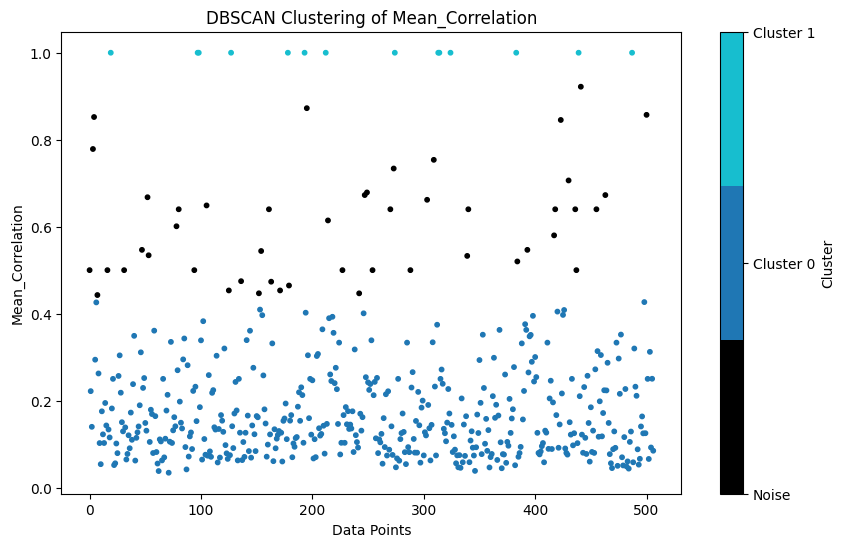

In [37]:
# Apply DBSCAN with the best parameters
dbscan = DBSCAN(eps=optimal_eps, min_samples=11)
clusters = dbscan.fit_predict(regions_df)
regions_df['Cluster'] = clusters

# Define a custom colormap where -1 (noise) is black and other clusters use high-contrast colors
unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))  # Use 'tab10' for better contrast
colors = np.vstack(([[0, 0, 0, 1]], colors))  # Add black color for noise
custom_cmap = ListedColormap(colors)

# Scatter plot for Mean_Correlation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(range(len(regions_df)), 
                       regions_df['Mean_Correlation'], 
                       c=regions_df['Cluster'], 
                       cmap=custom_cmap, 
                       s=10)

# Customize the color bar to label -1 as "Noise"
cbar = plt.colorbar(scatter, ticks=np.arange(-1, num_clusters))
cbar.ax.set_yticklabels(['Noise'] + [f'Cluster {i}' for i in range(num_clusters)])
cbar.set_label('Cluster')

# Plot titles and labels
plt.title('DBSCAN Clustering of Mean_Correlation')
plt.xlabel('Data Points')
plt.ylabel('Mean_Correlation')
plt.show()

### Hierarchical clustering 

Best silhouette score: 0.9518646927044355 for: 5 clusters
Best Calinski Harabasz score: 211396.91441514256 for: 10 clusters
Best Davies Bouldin score: 0.08625637786269799 for: 5 clusters


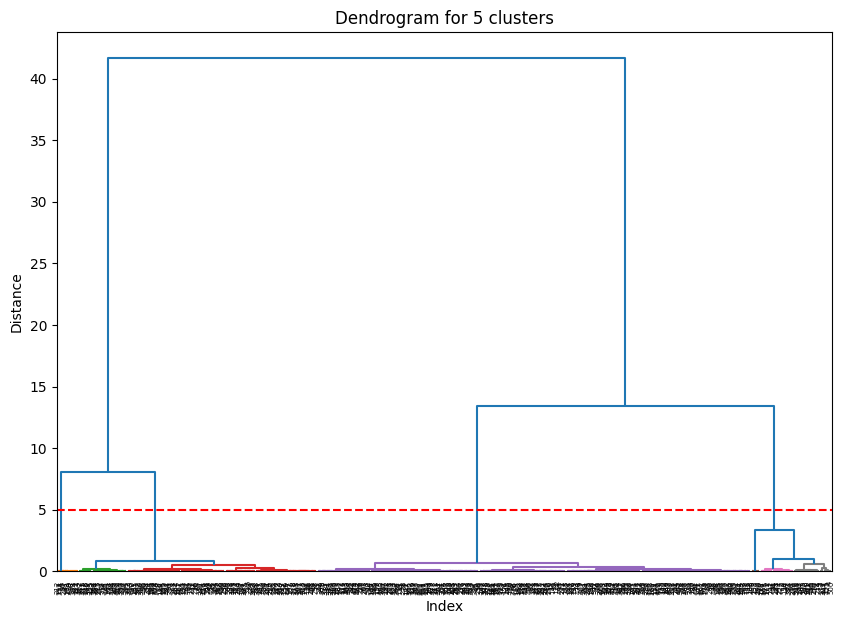

,Number of clusters,Silhouette Score,Calinski Harabasz Score,Davies Bouldin Score
0,2,0.852231,3374.818556,0.229794
1,3,0.913311,6053.168062,0.218245
2,4,0.945350,23037.595479,0.159114
3,5,0.951865,73695.312387,0.086256
4,6,0.929963,84362.425461,0.210259
5,7,0.815699,102634.449019,0.296372
6,8,0.595878,122899.906412,0.377117
7,9,0.601997,154889.617871,0.347266
8,10,0.591967,211396.914415,0.395029


In [63]:
data_values = regions_df.values

# Using ward method to create linked data
linked = linkage(data_values, method='ward')

max_clusters = 10
silhouette_scores = []
calinski_scores = []
davies_scores = []

for n_clusters in range(2, max_clusters + 1):
    clusters = fcluster(linked, t=n_clusters, criterion='maxclust')
    sil = silhouette_score(data_values, clusters)
    silhouette_scores.append((n_clusters, sil))
    cal = calinski_harabasz_score(data_values, clusters)
    calinski_scores.append((n_clusters, cal))
    dav = davies_bouldin_score(data_values, clusters)
    davies_scores.append((n_clusters, dav))

best_n_clusters_sil, best_silhouette_score = max(silhouette_scores, key=lambda x: x[1])
best_n_clusters_cal, best_calinski_score = max(calinski_scores, key=lambda x: x[1])
best_n_clusters_dav, best_davies_score = min(davies_scores, key=lambda x: x[1])

print(f'Best silhouette score: {best_silhouette_score} for: {best_n_clusters_sil} clusters')
print(f'Best Calinski Harabasz score: {best_calinski_score} for: {best_n_clusters_cal} clusters')
print(f'Best Davies Bouldin score: {best_davies_score} for: {best_n_clusters_dav} clusters')

# Dendrogram for best number of clusters - regarding silhouette
best_clusters = fcluster(linked, t=best_n_clusters_sil, criterion='maxclust')
plt.figure(figsize=(10, 7))
dendrogram(linked, color_threshold=0.7)
plt.axhline(y=5, color='r', linestyle='--')
plt.title(f'Dendrogram for {best_n_clusters_sil} clusters')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

# Display all of the obtained metrics
metrics_df = pd.DataFrame({
    'Number of clusters' : [i for i in range(2, max_clusters + 1)],
    'Silhouette Score': [sil[1] for sil in silhouette_scores],
    'Calinski Harabasz Score': [cal[1] for cal in calinski_scores],
    'Davies Bouldin Score': [dav[1] for dav in davies_scores]
})
metrics_df.head(10)


- Both the Silhouette Score and Davies-Bouldin Score identify 3 clusters as the optimal choice for hierarchical clustering, strongly suggesting that the data has a natural division into three well-defined groups.
-   While the high score at 10 clusters (Calinski-Harabasz Score) highlights the possibility of finer substructures, the lower Silhouette and Davies-Bouldin scores for this configuration suggest that these additional clusters might not be as meaningful.

### GMM

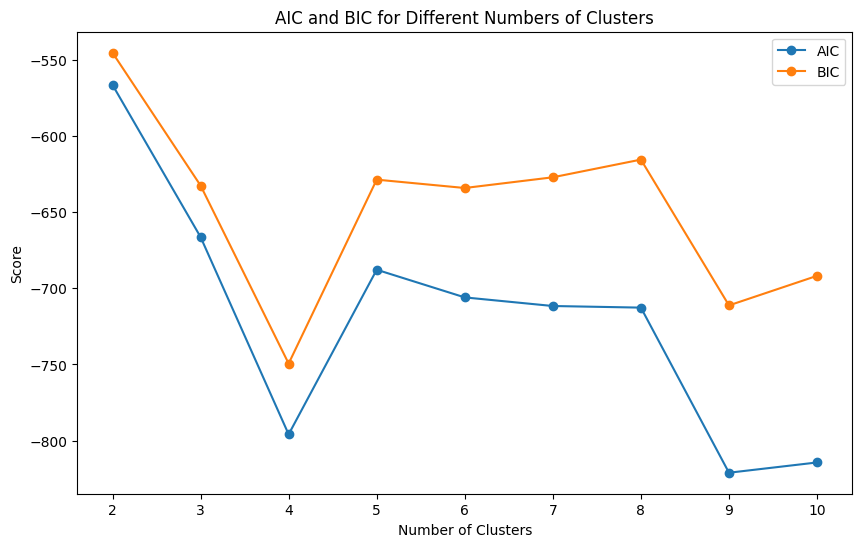

In [64]:
max_clusters = 10
aic_scores = []
bic_scores = []
best_gmm = None
best_n_clusters = 0

for n_clusters in range(2, max_clusters + 1):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(regions_df[['Mean_Correlation']])
    
    aic_scores.append(gmm.aic(regions_df[['Mean_Correlation']]))
    bic_scores.append(gmm.bic(regions_df[['Mean_Correlation']]))

# Visualization of AIC and BIC results
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), aic_scores, label='AIC', marker='o')
plt.plot(range(2, max_clusters + 1), bic_scores, label='BIC', marker='o')
plt.title('AIC and BIC for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

Lower AIC and BIC values suggest better clustering, therefore, taking the above graph into account, the best number of clusters would be 4.

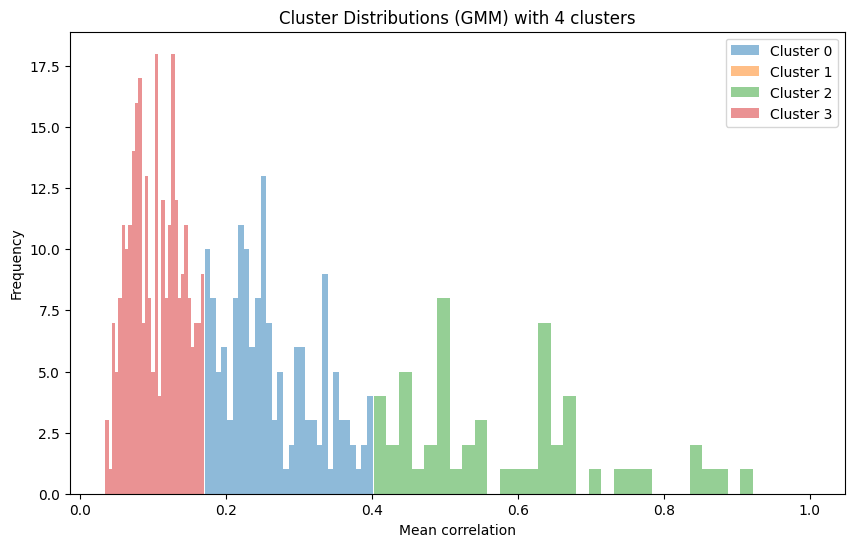

In [45]:
# Apply GMM for the best number of clusters - 4
best_gmm = GaussianMixture(n_components=4, random_state=42)
regions_df['GMM_Cluster'] = best_gmm.fit_predict(regions_df[['Mean_Correlation']])

# Visualization of distribution over clusters
plt.figure(figsize=(10, 6))
for i in range(4):
    cluster_data = regions_df[regions_df['GMM_Cluster'] == i]['Mean_Correlation']
    plt.hist(cluster_data, bins=30, alpha=0.5, label=f'Cluster {i}')

plt.title(f'Cluster Distributions (GMM) with 4 clusters')
plt.xlabel('Mean correlation')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Spectral Clustering

In [88]:
param_grid = {'n_clusters': range(2, 15)}

grid_search = ParameterGrid(param_grid)

best_silhouette_score = -1
best_calinski_harabasz_score = -1
best_davies_bouldin_score = float('inf')  
best_params_silhouette = None
best_params_calinski = None
best_params_davies = None

for params in grid_search:
    spectral = SpectralClustering(n_clusters=params['n_clusters'], affinity='nearest_neighbors', random_state=42)
    clusters = spectral.fit_predict(regions_df[['Mean_Correlation']])

    silhouette = silhouette_score(regions_df[['Mean_Correlation']], clusters)
    score_calinski_harabasz = calinski_harabasz_score(regions_df[['Mean_Correlation']], clusters)
    score_davies_bouldin = davies_bouldin_score(regions_df[['Mean_Correlation']], clusters)
    
    if silhouette is not None and silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        best_params_silhouette = params

    if score_calinski_harabasz > best_calinski_harabasz_score:
        best_calinski_harabasz_score = score_calinski_harabasz
        best_params_calinski = params

    if score_davies_bouldin < best_davies_bouldin_score:
        best_davies_bouldin_score = score_davies_bouldin
        best_params_davies = params
    
# Print the best results for each metric
print()
print(f"Best Silhouette Score: {best_silhouette:.4f} Number of clusters: {best_params_silhouette}")
print(f"Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f} Number of clusters: {best_params_calinski}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin:.4f} Number of clusters: {best_params_davies}")


Best Silhouette Score: -0.0161 Number of clusters: {'n_clusters': 13}
Best Calinski-Harabasz Index: 1.3719 Number of clusters: {'n_clusters': 8}
Best Davies-Bouldin Score: 0.6350 Number of clusters: {'n_clusters': 13}


- The negative Silhouette Score and low Calinski-Harabasz Index highlight that Spectral Clustering struggles to find meaningful clusters in this dataset.
- While the Davies-Bouldin Score suggests better separation at n_clusters=13, it may not be consistent with the overall cluster quality.
- Spectral Clustering depends heavily on the construction of the similarity graph (e.g., the affinity matrix or kernel used). Poorly constructed graphs can lead to suboptimal clustering.
- Based on all this, we can conclude that Spectral clustering is not appropriate algorithm for this clustering task.